# Séparation des jeux de données d'entraînement et de tests

In [17]:
from ift6758.data import load_cached_seasons_dataframe, load_cached_season_dataframe, summarize_df_by_shot_type

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(style="ticks")

In [18]:
df_training = load_cached_seasons_dataframe(2016,2019) 
df_test = load_cached_season_dataframe(2020) # on y touche pas jusqu'à la fin
# len(df_test)

In [19]:
goal_x = 89
goal_y = 0 

def new_variables(df):    
    ndf = df.copy()  # pour ne pas modifier l'original
    ndf["shotDistance"] = np.sqrt((goal_x - df["x"].abs())**2 + (df["y"] - goal_y)**2)
    ndf["shotAngle"] = np.degrees(np.arctan2((df["y"] - goal_y).abs(), (goal_x - df["x"].abs())))
    return ndf

new_variables(df_training)

,timeInPeriod,period,eventId,teamShot,typeEvent,x,y,shooter,goalie,typeShot,openNet,goalStrenght,gameId,season,gameType,shotDistance,shotAngle
0,01:11,1,8,TOR,shot-on-goal,-77.0,5.0,Mitch Marner,Craig Anderson,wrist,False,EV,2016020001,2016,2,13.000000,22.619865
1,02:53,1,11,OTT,shot-on-goal,86.0,13.0,Chris Kelly,Frederik Andersen,wrist,False,EV,2016020001,2016,2,13.341664,77.005383
2,04:01,1,15,OTT,shot-on-goal,23.0,-38.0,Cody Ceci,Frederik Andersen,wrist,False,EV,2016020001,2016,2,76.157731,29.931512
3,04:46,1,16,OTT,shot-on-goal,33.0,-15.0,Erik Karlsson,Frederik Andersen,slap,False,EV,2016020001,2016,2,57.974132,14.995079
4,06:46,1,24,TOR,shot-on-goal,-34.0,28.0,Martin Marincin,Craig Anderson,wrist,False,EV,2016020001,2016,2,61.717096,26.980231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,16:01,3,706,TBL,shot-on-goal,-59.0,-24.0,Anthony Cirelli,Anton Khudobin,snap,False,SH,2019030416,2019,3,38.418745,38.659808
327338,17:20,3,709,TBL,shot-on-goal,-81.0,3.0,Blake Coleman,Anton Khudobin,wrist,False,SH,2019030416,2019,3,8.544004,20.556045
327339,18:50,3,713,DAL,shot-on-goal,34.0,-6.0,John Klingberg,Andrei Vasilevskiy,snap,False,EV,2019030416,2019,3,55.326305,6.225829
327340,19:27,3,719,DAL,shot-on-goal,31.0,10.0,John Klingberg,Andrei Vasilevskiy,wrist,False,EV,2019030416,2019,3,58.855756,9.782407


C:\Users\pierr\AppData\Local\Temp\ipykernel_20740\3393816973.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("distance_bin", as_index=False)


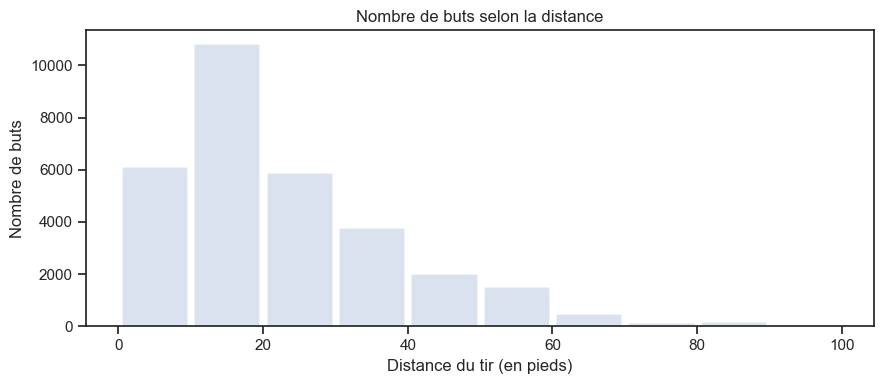

C:\Users\pierr\AppData\Local\Temp\ipykernel_20740\3393816973.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("distance_bin", as_index=False)


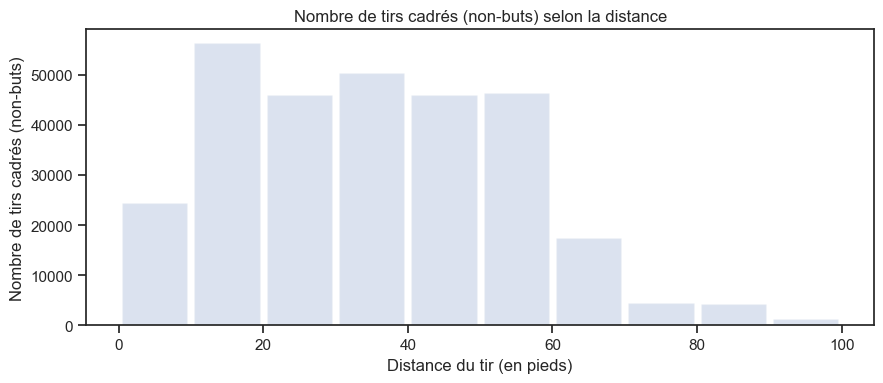

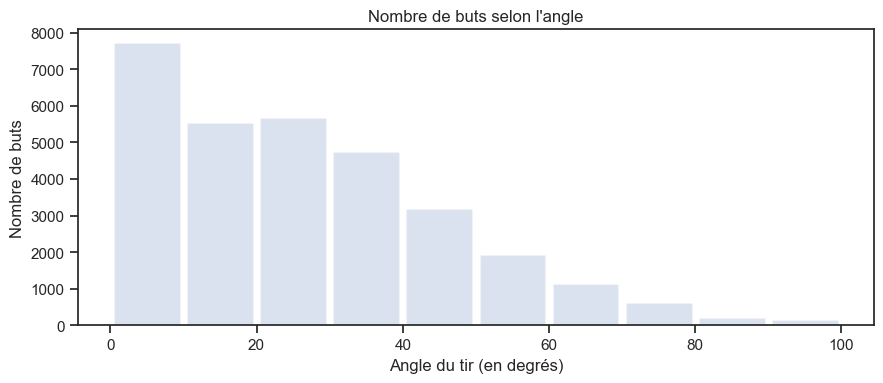

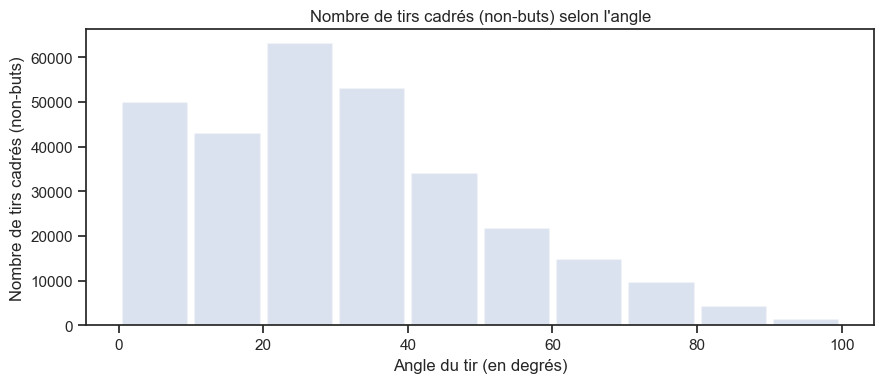

In [47]:
ndf_training = new_variables(df_training)

df_goals = ndf_training[ndf_training["typeEvent"] == "goal"].copy()
df_shots = ndf_training[ndf_training["typeEvent"] != "goal"].copy() # shots on target not goals

def bin_midpoint(interval):
    return (interval.left + interval.right) / 2

def hist_dist(df, event_label="tirs"):
    # --- Binning par distance (10 pieds)
    bin_size = 10
    max_dist = df["shotDistance"].max()
    
    # IMPORTANT: +bin_size pour que la dernière tranche inclue bien la distance max
    distance_bins = np.arange(0, max_dist + bin_size, bin_size)
    
    df["distance_bin"] = pd.cut(
        df["shotDistance"],
        bins=distance_bins,
        right=False,
        include_lowest=True
    )
    
    distance_summary = (
        df.groupby("distance_bin", as_index=False)
        .agg(
            number_of_shots=("shotDistance", "size")
        )
    )
    
    distance_summary["distance_mid"] = distance_summary["distance_bin"].apply(bin_midpoint)
    
    # --- Plot
    fig, ax1 = plt.subplots(figsize=(9, 4))
    
    ax1.bar(distance_summary["distance_mid"], distance_summary["number_of_shots"],
            alpha=0.2, width=bin_size * 0.9)
    ax1.set_xlabel("Distance du tir (en pieds)")
    ax1.set_ylabel(f"Nombre de {event_label}")
    ax1.set_title(f"Nombre de {event_label} selon la distance")
    
    plt.tight_layout()
    plt.show()

def hist_angle(df, event_label="tirs"):
    # --- Binning par distance (10 pieds)
    bin_size = 10
    max_angle = 100
    
    # IMPORTANT: +bin_size pour que la dernière tranche inclue bien la distance max
    angle_bins = np.arange(0, max_angle + bin_size, bin_size)
    
    df["angle_bin"] = pd.cut(
        df["shotAngle"],
        bins=angle_bins,
        right=False,
        include_lowest=True
    )
    
    angle_summary = (
        df.groupby("angle_bin", as_index=False, observed=True)  # bins non vides seulement
          .agg(number_of_shots=("shotAngle", "size"))
    )
    
    angle_summary["angle_mid"] = angle_summary["angle_bin"].apply(bin_midpoint)
    
    # --- Plot
    fig, ax1 = plt.subplots(figsize=(9, 4))
    
    ax1.bar(angle_summary["angle_mid"], angle_summary["number_of_shots"],
            alpha=0.2, width=bin_size * 0.9)
    ax1.set_xlabel("Angle du tir (en degrés)")
    ax1.set_ylabel(f"Nombre de {event_label}")
    ax1.set_title(f"Nombre de {event_label} selon l'angle")
    
    plt.tight_layout()
    plt.show()

hist_dist(df_goals, event_label="buts")
hist_dist(df_shots, event_label="tirs cadrés (non-buts)")

hist_angle(df_goals, event_label="buts")
hist_angle(df_shots, event_label="tirs cadrés (non-buts)")
    


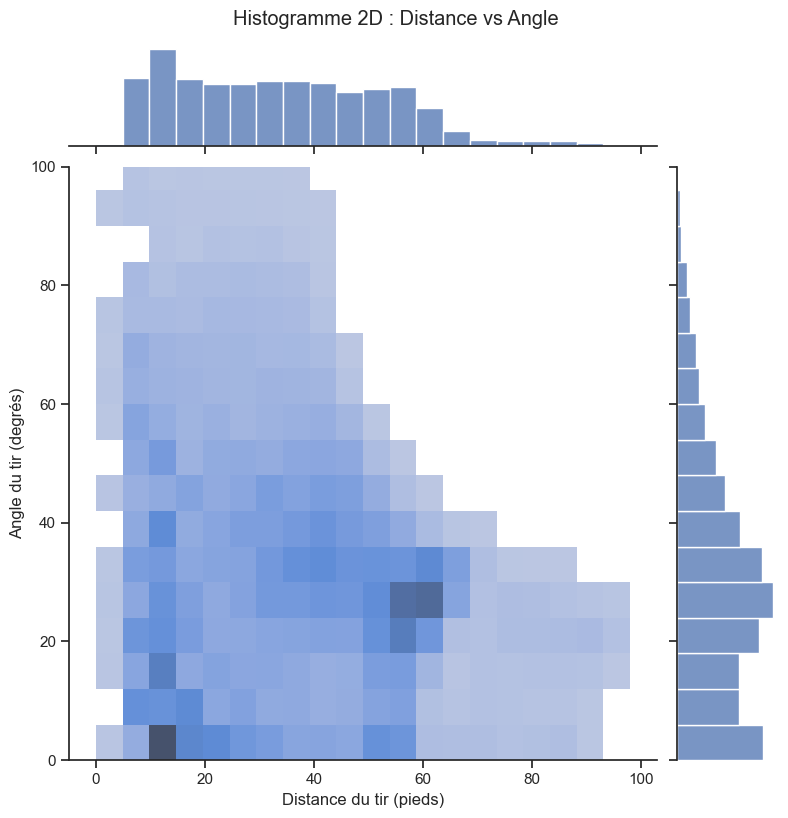

In [61]:
df_all = ndf_training.copy()

g = sns.jointplot(
    data=df_all,
    x="shotDistance",
    y="shotAngle",
    kind="hist",              # 2D histogram
    bins=(20,30),             # ajuste si trop grossier/fin
    height=8
)

g.ax_joint.set_ylim(0, 100)
g.set_axis_labels("Distance du tir (pieds)", "Angle du tir (degrés)")
g.fig.suptitle("Histogramme 2D : Distance vs Angle", y=1.02)
plt.show()

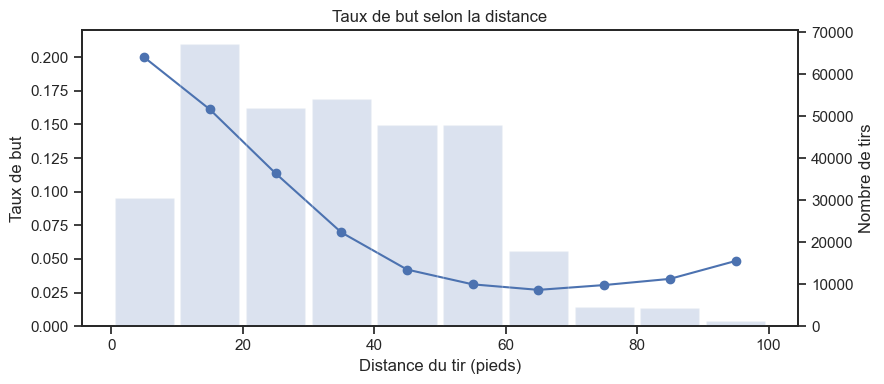

In [64]:
shots_and_goals = ndf_training.copy()

# indicateur temporaire 0/1 (pas besoin de le garder après)
shots_and_goals["isGoal_tmp"] = (shots_and_goals["typeEvent"].str.lower() == "goal").astype(int)

bin_size = 10  # par tranche de 10 pieds
max_dist = shots_and_goals["shotDistance"].max()
distance_bins = np.arange(0, max_dist + bin_size, bin_size)  # +bin_size pour inclure la fin

shots_and_goals["distance_bin"] = pd.cut(
    shots_and_goals["shotDistance"],
    bins=distance_bins,
    right=False,
    include_lowest=True
)

distance_summary = (
    shots_and_goals.groupby("distance_bin", as_index=False, observed=True)
    .agg(
        goal_probability=("isGoal_tmp", "mean"),   # = #goals / #total
        number_of_shots=("isGoal_tmp", "size")
    )
)

distance_summary["distance_mid"] = distance_summary["distance_bin"].apply(bin_midpoint)

fig, ax1 = plt.subplots(figsize=(9, 4))

ax1.plot(distance_summary["distance_mid"], distance_summary["goal_probability"], marker="o")
ax1.set_xlabel("Distance du tir (pieds)")
ax1.set_ylabel("Taux de but")
ax1.set_title(f"Taux de but selon la distance")
ax1.set_ylim(0, max(distance_summary["goal_probability"].max() * 1.1, 0.05))

ax2 = ax1.twinx()
ax2.bar(distance_summary["distance_mid"], distance_summary["number_of_shots"],
        alpha=0.2, width=bin_size * 0.9)
ax2.set_ylabel("Nombre de tirs")

plt.tight_layout()
plt.show()

In [ ]:
shots_and_goals = ndf_training.copy()

# indicateur temporaire 0/1 (pas besoin de le garder après)
shots_and_goals["isGoal_tmp"] = (shots_and_goals["typeEvent"].str.lower() == "goal").astype(int)

bin_size = 10  # par tranche de 10 pieds
max_dist = shots_and_goals["shotDistance"].max()
distance_bins = np.arange(0, max_dist + bin_size, bin_size)  # +bin_size pour inclure la fin

shots_and_goals["distance_bin"] = pd.cut(
    shots_and_goals["shotDistance"],
    bins=distance_bins,
    right=False,
    include_lowest=True
)

distance_summary = (
    shots_and_goals.groupby("distance_bin", as_index=False, observed=True)
    .agg(
        goal_probability=("isGoal_tmp", "mean"),   # = #goals / #total
        number_of_shots=("isGoal_tmp", "size")
    )
)

distance_summary["distance_mid"] = distance_summary["distance_bin"].apply(bin_midpoint)

fig, ax1 = plt.subplots(figsize=(9, 4))

ax1.plot(distance_summary["distance_mid"], distance_summary["goal_probability"], marker="o")
ax1.set_xlabel("Distance du tir (pieds)")
ax1.set_ylabel("Taux de but")
ax1.set_title(f"Taux de but selon la distance — saison {season}-{season+1}")
ax1.set_ylim(0, max(distance_summary["goal_probability"].max() * 1.1, 0.05))

ax2 = ax1.twinx()
ax2.bar(distance_summary["distance_mid"], distance_summary["number_of_shots"],
        alpha=0.2, width=bin_size * 0.9)
ax2.set_ylabel("Nombre de tirs")

plt.tight_layout()
plt.show()

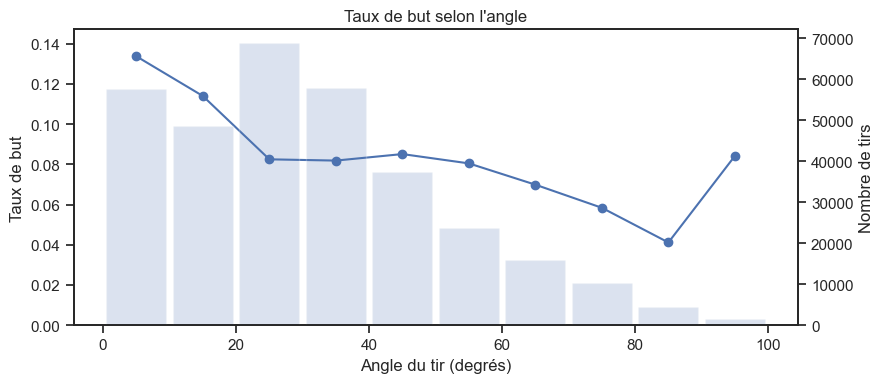

In [66]:
shots_and_goals = ndf_training.copy()

# indicateur temporaire 0/1
shots_and_goals["isGoal_tmp"] = (shots_and_goals["typeEvent"].str.lower() == "goal").astype(int)

# --- Angle
bin_size = 10          # par tranche de 10 degrés (tu peux mettre 5 si tu veux plus fin)
max_angle = 100        # limite souhaitée

# on garde seulement les tirs dont l'angle est dans [0, 100]
shots_and_goals = shots_and_goals[shots_and_goals["shotAngle"].between(0, max_angle)].copy()

angle_bins = np.arange(0, max_angle + bin_size, bin_size)

shots_and_goals["angle_bin"] = pd.cut(
    shots_and_goals["shotAngle"],
    bins=angle_bins,
    right=False,
    include_lowest=True
)

angle_summary = (
    shots_and_goals.groupby("angle_bin", as_index=False, observed=True)
    .agg(
        goal_probability=("isGoal_tmp", "mean"),
        number_of_shots=("isGoal_tmp", "size")
    )
)

angle_summary["angle_mid"] = angle_summary["angle_bin"].apply(bin_midpoint)

fig, ax1 = plt.subplots(figsize=(9, 4))

ax1.plot(angle_summary["angle_mid"], angle_summary["goal_probability"], marker="o")
ax1.set_xlabel("Angle du tir (degrés)")
ax1.set_ylabel("Taux de but")
ax1.set_title(f"Taux de but selon l'angle")
ax1.set_ylim(0, max(angle_summary["goal_probability"].max() * 1.1, 0.05))

ax2 = ax1.twinx()
ax2.bar(angle_summary["angle_mid"], angle_summary["number_of_shots"],
        alpha=0.2, width=bin_size * 0.9)
ax2.set_ylabel("Nombre de tirs")

plt.tight_layout()
plt.show()

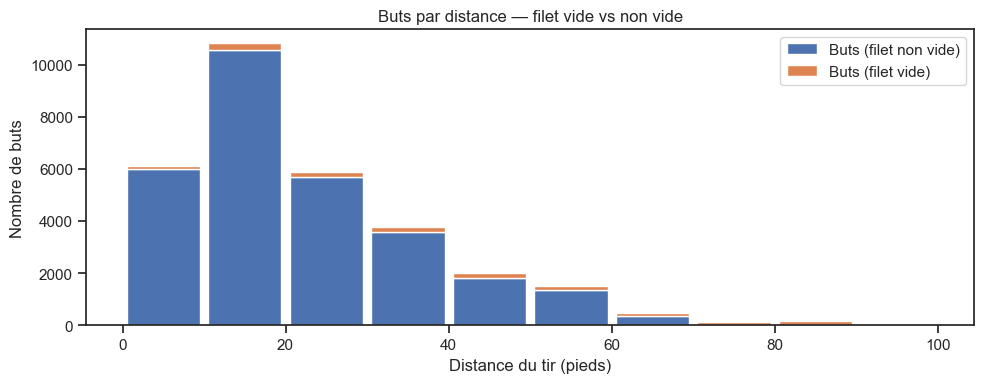

In [70]:
ndf_training = new_variables(df_training)

# 1) Garder seulement les buts
df_goals = ndf_training[ndf_training["typeEvent"].str.lower() == "goal"].copy()

# 2) Empty net: NaN -> 0, cast en int
df_goals["openNet"] = df_goals["openNet"].fillna(0).astype(int)

# 3) Bins de distance
bin_size = 10
max_dist = df_goals["shotDistance"].max()
distance_bins = np.arange(0, max_dist + bin_size, bin_size)

df_goals["distance_bin"] = pd.cut(
    df_goals["shotDistance"],
    bins=distance_bins,
    right=False,
    include_lowest=True
)

# 4) Compter par bin et par emptyNet
summary = (
    df_goals.groupby(["distance_bin", "openNet"], observed=True)
            .size()
            .unstack(fill_value=0)
            .reset_index()
)

# colonnes: 0 = non empty net, 1 = empty net (si présent)
if 0 not in summary.columns: summary[0] = 0
if 1 not in summary.columns: summary[1] = 0

def bin_midpoint(interval):
    return (interval.left + interval.right) / 2

summary["distance_mid"] = summary["distance_bin"].apply(bin_midpoint)

# 5) Plot (barres groupées)
x = summary["distance_mid"].to_numpy()
width = bin_size * 0.42

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x, summary[0], width=bin_size*0.9, label="Buts (filet non vide)")
ax.bar(x, summary[1], width=bin_size*0.9, bottom=summary[0], label="Buts (filet vide)")

ax.set_xlabel("Distance du tir (pieds)")
ax.set_ylabel("Nombre de buts")
ax.set_title(f"Buts par distance — filet vide vs non vide")
ax.legend()
plt.tight_layout()
plt.show()